In [2]:
from qiskit import *

# Advanced circuits (optional)

## Parameterized gates

Do you remember the rotation gates `rx`, `ry`, `rz` introduced in the first notebook? When creating one of these gates, you also have to specify the angle of rotation. The rotation gates are therefore examples of __parametrized__ gates. Other examples are the `u`, `p`, and `cu` gates.

Current quantum algorithms that can be used on [NISQ](https://en.wikipedia.org/wiki/Noisy_intermediate-scale_quantum_era) devices are called variational quantum algorithms ([VQE](https://en.wikipedia.org/wiki/Variational_quantum_eigensolver), QAOA, quantum machine learning, etc.). These algorithms work by defining a parameterized circuit ansatz for a given problem and then iteratively optimizing the parameters in the circuit to reach the solution. Therefore, it is quite important to know how to handle parameters in circuit.

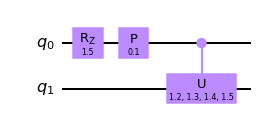

In [3]:
qc = QuantumCircuit(2)
qc.rz(1.5,0) # rotation angle
qc.p(0.1,0) # quantum phase
qc.cu(1.2,1.3,1.4,1.5, 0,1) # controlled-unitary
qc.draw('mpl')

Instead of binding the parameter values to the circuit on construction you can also leave the parameters as variables in the circuit.

ParameterView([Parameter(θ)])


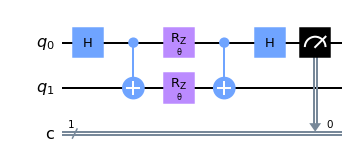

In [4]:
from qiskit.circuit import Parameter

theta = Parameter('θ') # define a single variable theta

qc = QuantumCircuit(2,1)
qc.h(0)
qc.cx(0,1)
qc.rz(theta, range(2)) # assign rotation angle to parameter variable theta
qc.cx(0,1)
qc.h(0)
qc.measure(0, 0)

print(qc.parameters) # get circuit parameters

qc.draw('mpl')

Before we are able to run a circuit though, we need to bind/assign the circuit parameters to some concrete values.

The `bind_parameters` method accepts a dictionary mapping Parameters to values, and returns a new circuit with each parameter replaced by its corresponding value.

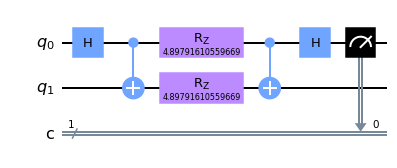

In [5]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = []
for theta_val in theta_range:
  bound_qc = qc.bind_parameters({theta: theta_val}) # assign values to circuit parameters
  circuits.append(bound_qc) # list of circuits each with different assigned parameter values

circuits[99].draw('mpl')

Let's run each circuit on the QASM simulator backend and plot the number of counts as a function of the rotation angle $\theta$.

In [6]:
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

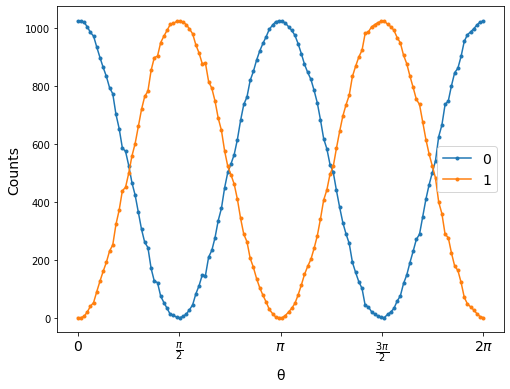

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

$\color{red}{\text{Optional Exercise 1: How does the period of oscillation change if we use the 3-qubit GHZ circuit instead?}}$

What about the 4,5,... qubit analog? Try it out if you are unsure.

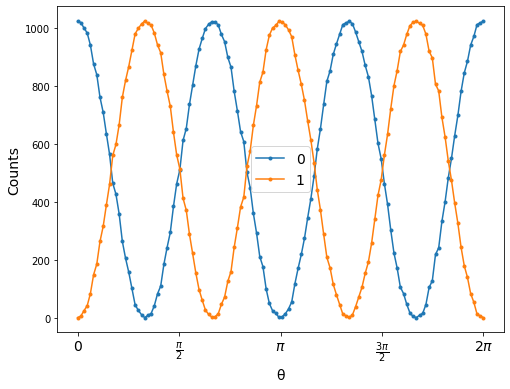

In [8]:
#Your code goes here

qc = QuantumCircuit(3,1)

theta = Parameter('θ') # define a single variable theta
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
qc.rz(theta, range(3)) # assign rotation angle to parameter variable theta
qc.cx(0,2)
qc.cx(0,1)
qc.h(0)
qc.measure(0, 0)

circuits = []
for theta_val in theta_range:
  bound_qc = qc.bind_parameters({theta: theta_val}) # assign values to circuit parameters
  circuits.append(bound_qc) # list of circuits each with different assigned parameter values

backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1')
ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

### Different parameters

You can of course also have multiple different parameters in one circuit either by specifying different `Parameter` (`Parameter['1']`, `Parameter['2']`, etc.) or by using a `ParameterVector`.

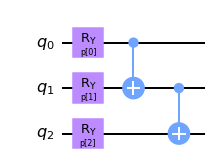

In [9]:
from qiskit.circuit import ParameterVector

p = ParameterVector('p', 6)  # define 6 different parameters

n = 3
qc = QuantumCircuit(n)

for i in range(n):
  qc.ry(p[i], i)  # apply RY(p[i]) on qubit i

qc.cx(0,1)
qc.cx(1,2)

qc.draw('mpl')

$\color{red}{\text{Exercise 2: Add another layer of Ry rotations to the circuit}}$

I.e. apply an additional Ry gate to each qubit with parameters `p[3], p[4], p[5]` respectively.

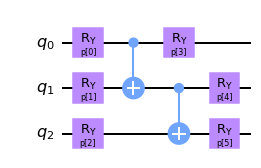

In [10]:
#Your code goes here

for i in range(n):
  qc.ry(p[i+n], i)  # RY(p[i+3]) on qubit i

qc.draw('mpl')

$\color{red}{\text{Exercise 3: Bind parameters to the circuit}}$

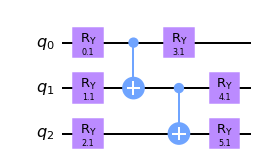

In [11]:
parameter_values = [0.1, 1.1, 2.1, 3.1, 4.1, 5.1]

#bound_qc = qc.bind_parameters({p: parameter_values})
bound_qc = qc.bind_parameters(parameter_values)

bound_qc.draw('mpl')

*Hint for exercise 3:* $\color{white}{\text{You can just pass the array as it is.}}$

## Predefined composite instructions

Qiskit has some predefined circuits that are useful for many applications (e.g. quantum chemistry, quantum simulation, quantum machine learning etc.)

For example, the [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit is a heuristic trial wave function used as Ansatz in chemistry applications or classification circuits in machine learning. The circuit consists of alternating layers of rotations and entangling gates. The entanglement pattern can be user-defined or selected from a predefined set. It is called `RealAmplitudes` since the prepared quantum states will only have real amplitudes, the complex part is always 0.

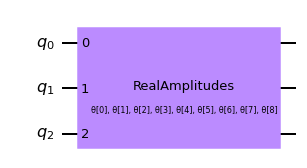

In [12]:
from qiskit.circuit.library import *

qc1 = RealAmplitudes(3, reps=2) # 3 quibts, 2 layers
qc1.draw('mpl')

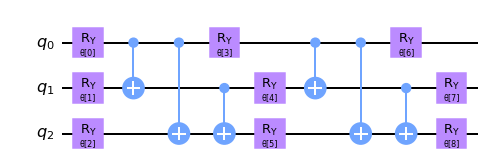

In [13]:
qc1 = qc1.decompose() # decompose composite instruction to see individual gates
qc1.draw('mpl')

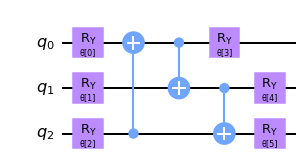

In [14]:
qc2 = RealAmplitudes(3, reps=1, entanglement='circular')
qc2 = qc2.decompose()
qc2.draw('mpl')

$\color{red}{\text{Exercise 4: Assign some parameters to one of the circuits above}}$

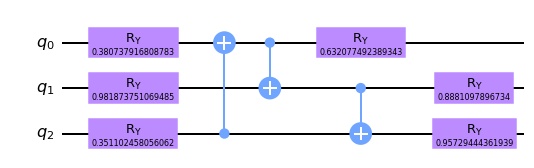

In [15]:
#Your code goes here

bound_qc2 = qc2.bind_parameters(np.random.random(6))
bound_qc2.draw('mpl')

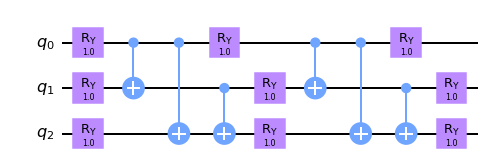

In [16]:
bound_qc1 = qc1.bind_parameters(np.ones(9))
bound_qc1.draw('mpl')

These notebooks are comprised of text and code taken from Qiskit's [documentation](https://qiskit.org/documentation/), [tutorials](https://qiskit.org/documentation/tutorials.html#quantum-circuits), [textbook](https://qiskit.org/textbook/preface.html), and previous challenges facilitated by Qiskit.